In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Amazon Fine Food Reviews Analysis using T-SNE plots.


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

#### Basic information about the downloaded dataset<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

#### Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Our main objective for this analysis is to train a model which can seperate the postive and negative reviews.
In this problem we will apply dimensionality reduction techniques called T-SNE to get an idea if the data can be seperated based on its polarity, i.e. if the review is postive or negative.

#### While pre-processing the original dataset we have taken into consideration the following points.

1. We will classify a review to be positive if and only if the corresponding Score for the given review is 4 or 5.
2. We will classify a review to be negative if and only if the corresponding Score for the given review is 1 or 2.
3. We will ignore the reviews for the time being which has a Score rating of 3. Because 3 can be thought of as a neutral review. It's neither negative nor positive.
4. We will remove the duplicate entries from the dataset.
5. For this problem we will consider a sample size of 10000 reviews sampled randomly from the original dataset. I have done this because I don't have a huge RAM size (12 GB to be specific). 
6. We will train our final mdel using four featurizations -> bag of words model, tf-idf model, average word-to-vec model and tf-idf weighted word-to-vec model.
7. So at end of the training the model will be trained on the above four featurizations to determine if a given review is positive or negative (Determining the sentiment polarity of the Amazon reviews)

In [9]:
#Importing all the neccessary libraries
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import warnings
warnings.filterwarnings("ignore")

#### The immediate code block below does the following things :

1. Load the Amazon dataset.
2. Classify the reviews initially based on their score rating and give them a 'Positve' or a 'Negative' tag.
3. Remove duplicate/redundant datas.
4. Get an idea of how much percentage data were actually duplicates.
5. Plot a histogram which will display the distribution of the number of positive and negative reviews after de-duplication.


The shape of the filtered matrix : (525814, 12)

The median score values : 4.27914813983652

The number of positive and negative reviews before the removal of duplicate data.
Positive    443777
Negative     82037
Name: SentimentPolarity, dtype: int64

The shape of the data matrix after deduplication : (364171, 12)

The median score values after deduplication : 4.27579626054793

The number of positive and negative reviews after the removal of duplicate data.
Positive    307061
Negative     57110
Name: SentimentPolarity, dtype: int64

Checking to see how much percentage of data still remains.

Percentage of redundant data removed : 30.741478926008057

Percentage of original data retained : 69.25852107399194

First 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Class_Labels
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive,1


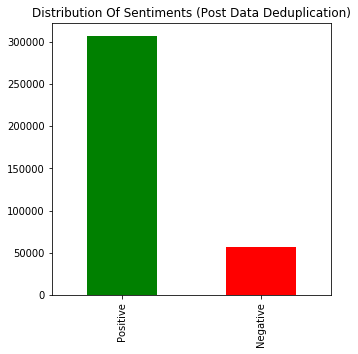

In [10]:
#Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews.
connection_sqlobject = sqlite3.connect('database.sqlite') 

#Filter only positive and negative reviews. Do nbot consider reviews with score = 3.
#not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, connection_sqlobject)

#Give reviews with Score > 3 a 'Positive' tag, and reviews with a score < 3 a 'Negative' tag.
filtered_data['SentimentPolarity'] = filtered_data['Score'].apply(lambda x : 'Positive' if x > 3 else 'Negative')
filtered_data['Class_Labels'] = filtered_data['SentimentPolarity'].apply(lambda x : 1 if x == 'Positive' else 0)

#Display information about the dataset before the removal of duplicate data.
print("\nThe shape of the filtered matrix : {}".format(filtered_data.shape))
print("\nThe median score values : {}".format(filtered_data['Score'].mean()))
print("\nThe number of positive and negative reviews before the removal of duplicate data.")
print(filtered_data["SentimentPolarity"].value_counts())

#Removing duplicate entries based on past knowledge.
filtered_duplicates=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

#Removing the entries where HelpfulnessNumerator > HelpfulnessDenominator.
final_data=filtered_duplicates[filtered_duplicates.HelpfulnessNumerator <= filtered_duplicates.HelpfulnessDenominator]

#Display information about the dataset after the removal of duplicate data.
print("\nThe shape of the data matrix after deduplication : {}".format(final_data.shape))
print("\nThe median score values after deduplication : {}".format(final_data['Score'].mean()))
print("\nThe number of positive and negative reviews after the removal of duplicate data.")
print(final_data["SentimentPolarity"].value_counts())

#Display the above information in a bar graph for the deduplicated table.
final_data["SentimentPolarity"].value_counts().plot(kind='bar',color=['green','red'],title='Distribution Of Sentiments (Post Data Deduplication)',figsize=(5,5))

#Checking to see how much % of data still remains.
print("\nChecking to see how much percentage of data still remains.")
retained_per = (final_data['SentimentPolarity'].size*1.0)/(filtered_data['SentimentPolarity'].size*1.0)*100
removed_per = 100 - retained_per
print("\nPercentage of redundant data removed : {}".format(removed_per))
print("\nPercentage of original data retained : {}".format(retained_per))

#Display the first 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.
print("\nFirst 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.")
final_data.head(5)

#### In this code block :

1. I am creating a sample dataset of 10000 reviews sampled randomly from the de-duplicated dataset. 
2. Displaying information about the number of postive and negative reviews in the sampled dataset, using a Histogram.


The shape of the sampled dataset :  (10000, 13)

The shape of the sampled dataset after dropping unwanted columns :  (10000, 4)

Printing the number of positive and negative reviews after sampling
Positive    8402
Negative    1598
Name: SentimentPolarity, dtype: int64

First 10 rows of the sampled_dataset.


,Time,Text,SentimentPolarity,Class_Labels
0,1351209600,Okay so I work at a Family Dollar in St. Louis...,Positive,1
1,1351209600,We have enjoyed using this product. I like it...,Positive,1
2,1351209600,"This is the 3rd meat grinder I have purchased,...",Positive,1
3,1351209600,I like the convenience of protein bars for an ...,Positive,1
4,1351209600,My mother loves this coffee and the pods fit h...,Positive,1
5,1351209600,Wolfgang Puck's Jamaica Me Crazy is that wonde...,Positive,1
6,1351123200,My 7 cats like this food but it is a little yu...,Positive,1
7,1351123200,Ive been watching my calories & when I going p...,Positive,1
8,1351123200,We rescued a mini schnauzer and I wanted to fe...,Negative,0
9,1351123200,This is great popcorn. We make it in a stir c...,Positive,1


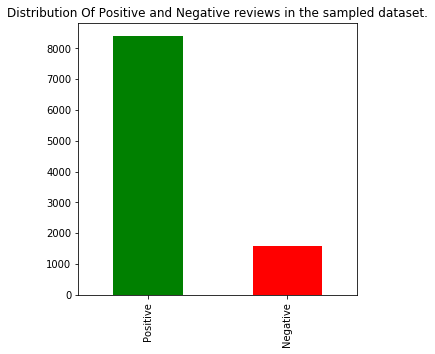

In [11]:
'''Creating a sampled dataset containing 10000 elements selected randomly from the actual dataset.'''
#Creating a subset of the "final_data" table with randomly selecting 10000 samples
sampled_dataset = final_data.sample(n=10000, replace=False, random_state=0).reset_index()
print("\nThe shape of the sampled dataset : ", sampled_dataset.shape)

#Dropping unwanted columns for now.
sampled_dataset=sampled_dataset.drop(labels=['index','Id','ProductId', 'UserId', 'Score', 'ProfileName','HelpfulnessNumerator', 'HelpfulnessDenominator','Summary'], 
                                     axis=1)
print("\nThe shape of the sampled dataset after dropping unwanted columns : ", sampled_dataset.shape)

#Sorting data according to Time in ascending order => Time Based Splitting Step 1.
sampled_dataset=sampled_dataset.sort_values('Time', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')
sampled_dataset = sampled_dataset.reset_index()
sampled_dataset=sampled_dataset.drop(labels=['index'], axis=1)

#Print the number of positive and negative reviews after removal of duplicate data and random sampling 
print("\nPrinting the number of positive and negative reviews after sampling")
print(sampled_dataset["SentimentPolarity"].value_counts())

#Display the above information in a bar graph
sampled_dataset["SentimentPolarity"].value_counts().plot(kind='bar',color=['green','red'],title='Distribution Of Positive and Negative reviews in the sampled dataset.',
                                                         figsize=(5,5))
sampled_dataset.head(5)

#Display the first 10 rows of the sampled_dataset.
print("\nFirst 10 rows of the sampled_dataset.")
sampled_dataset.head(10)

#### In this code block :

1. We define two functions which will remove the HTML tags and punctuations from each review.
2. At the end of this code block, each review will contain texts which will only contain alphabetical strings. 
3. We will apply techniques such as stemming and stopwords removal.
3. We will create two columns in the sampled dataset - 'CleanedText' and 'RemovedHTML'.
4. 'CleanedText' column will basically contain the data corpus after stemming the each reviews and removing stopwords from each review. We will use this for our Bag of Word model.
5. 'RemovedHTML' column will contain the data corpus from which only the HTML tags and punctuations are removed. We will use this column for our TF-IDF model, Average Word2Vec model and TF-IDF weighted average Word2Vec model.
6. Store the final table in a dataset called 'sampled_dataset' for future use.

In [12]:
'''Data Cleaning Stage. Clean each review from the sampled Amazon Dataset.'''
#Data Cleaning Stage. Clean each review from the sampled Amazon Dataset

#Function to clean html tags from a sentence
def removeHtml(sentence): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text

#Function to keep only words containing letters A-Z and a-z. This will remove all punctuations, special characters etc.
def removePunctuations(sentence):
    cleaned_text  = re.sub('[^a-zA-Z]',' ',sentence)
    return cleaned_text

#Stemming and stopwords removal
import re
from nltk.stem.snowball import SnowballStemmer
sno = SnowballStemmer(language='english')

#Removing the word 'not' from stopwords
default_stopwords = set(stopwords.words('english'))
remove_not = set(['not'])
custom_stopwords = default_stopwords - remove_not

#Building a data corpus by removing all stopwords except 'not'
data_corpus = []
for sentence in sampled_dataset['Text'].values:
    review = sentence
    review = removeHtml(review) #Remove HTMl tags
    review = removePunctuations(review) #Remove Punctuations
    review = review.lower() #Convert each review to lower case
    review = review.split() #Split each sentence into words
    review = [sno.stem(word) for word in review if not word in set(custom_stopwords)]
    review = ' '.join(review)
    data_corpus.append(review)

print("\nThe length of the data corpus is : {}".format(len(data_corpus)))

#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
sampled_dataset['CleanedText']=data_corpus

print("\nPrinting the number of positive and negative reviews after data cleaning.")
print(sampled_dataset['SentimentPolarity'].value_counts())

#Display the first 10 rows of the sampled_dataset.
print("\nFirst 10 rows of the sampled_dataset.")
sampled_dataset.head(10)

#Building a data corpus by all HTML tags and punctuations. Stopwords are preserved.
data_corpus = []
for sentence in sampled_dataset['Text'].values:
    review = sentence
    review = removeHtml(review) #Remove HTMl tags
    review = removePunctuations(review) #Remove Punctuations
    data_corpus.append(review)

print("\nThe length of the data corpus is : {}".format(len(data_corpus)))

#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
sampled_dataset['RemovedHTML']=data_corpus

#Store final table into an SQlLite table for future.
connection_sqlobject = sqlite3.connect('sampled_dataset_PCA_10000.sqlite')
c=connection_sqlobject.cursor()
connection_sqlobject.text_factory = str
sampled_dataset.to_sql('Reviews', connection_sqlobject, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)


The length of the data corpus is : 10000

Printing the number of positive and negative reviews after data cleaning.
Positive    8402
Negative    1598
Name: SentimentPolarity, dtype: int64

First 10 rows of the sampled_dataset.

The length of the data corpus is : 10000


### In this code block : We define a function which is used to seperate the positive and the negative data points for any input dataset using their corresponding class labels, using dimensionality reduction techniques such as t-sne.

In [3]:
def tsne(dataset, labels, perplexity):
    '''This function is used to plot the t-sne for any input dataset using their corresponding class labels,
    using two dimensions.'''
    #TSNE for cleaned data, #10000 data points
    from MulticoreTSNE import MulticoreTSNE as TSNE

    #Starting TSNE dataset transform
    model = TSNE(n_components=2, random_state=0, n_jobs=8, perplexity=perplexity, n_iter=5000)
    tsne_data = model.fit_transform(dataset)

    #Creating a new data frame which help us in ploting the result data
    tsne_data = np.vstack((tsne_data.T, labels)).T
    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "labels"))
    
    #Info
    print("\nT-SNE Plot for perplexity = {}".format(perplexity))
    
    # Ploting the result of tsne
    sns.FacetGrid(tsne_df, hue="labels", size=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
    plt.show()    

### Creating Bag of Words model using 'CleanedText'. 

Creating the BOW vectors using the cleaned corpus
The type of count vectorizer  <class 'numpy.ndarray'>
The shape of the data-cleaned BOW vectors  (10000, 13700)
The number of unique words in the data-cleaned BOW 13700
The shape of the standardized data is : (10000, 13700)
The shape of the dataset is : (10000, 13700)
The size of class labels is : 10000

Plotting the TSNE for the Bag of Words model.

T-SNE Plot for perplexity = 20


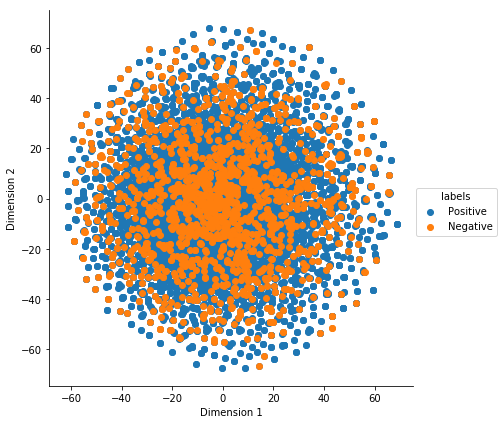


T-SNE Plot for perplexity = 50


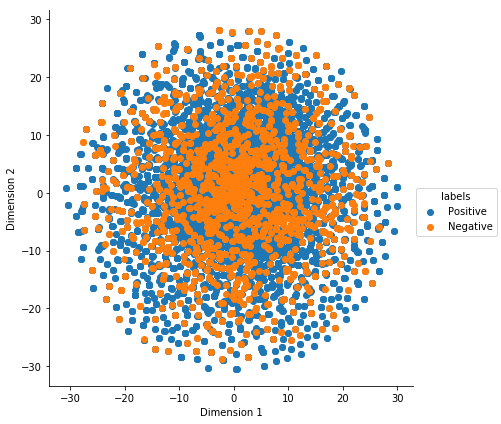


T-SNE Plot for perplexity = 80


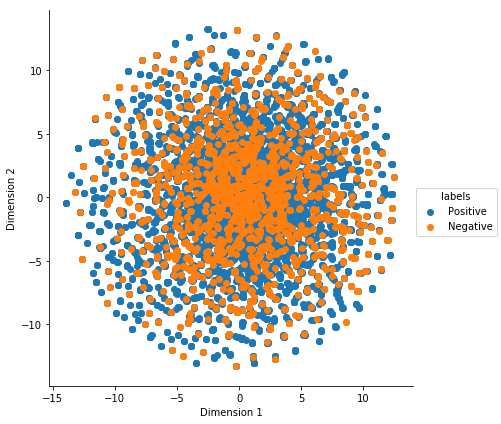

In [8]:
'''T-SNE for the Bag of Words model using the  cleaned reviews.'''
#Bag of Words model creation using cleaned text 

#Using the SQLite Table to read data from a previosuly saved table.
connection_sqlobject = sqlite3.connect('sampled_dataset_PCA_10000.sqlite') 
sampled_dataset = pd.read_sql_query(""" SELECT * FROM Reviews """, connection_sqlobject)

#Initializing the BOW constructor
cv_object = CountVectorizer()

#Creating the BOW matrix from cleaned data corpus. Only 'not' is preserved from stopwords.
print("Creating the BOW vectors using the cleaned corpus")
bow_matrix_10000 = cv_object.fit_transform(sampled_dataset['CleanedText']).toarray()
print("The type of count vectorizer ",type(bow_matrix_10000))
print("The shape of the data-cleaned BOW vectors ",bow_matrix_10000.shape)
print("The number of unique words in the data-cleaned BOW", len(bow_matrix_10000[0]))

#Colum Standardization of the Bag of Words vector created using cleaned data
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler(with_mean=False)
standardized_data = scalar.fit_transform(bow_matrix_10000)
print("The shape of the standardized data is : {}".format(standardized_data.shape))

#Creating a dataframe from the standardized data
dataset = pd.DataFrame(standardized_data)
print("The shape of the dataset is : {}".format(dataset.shape))

#Picking up the labels from the sampled dataset
labels = sampled_dataset['SentimentPolarity']
print("The size of class labels is : {}".format(len(labels)))

#Free memory allocations. 'bow_matrix_10000' and 'standardized_data' matrices are no longer needed.
del(bow_matrix_10000, standardized_data, sampled_dataset)

#Plot the t-sne 
print("\nPlotting the TSNE for the Bag of Words model.")
tsne(dataset, labels, 20)  #T-SNE with perplexity = 20
tsne(dataset, labels, 50)  #T-SNE with perplexity = 50
tsne(dataset, labels, 80)  #T-SNE with perplexity = 80

### Creating a TF-IDF model using 'RemovedHTML' texts. 


The type of count vectorizer :  <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
The shape of the TFIDF vectorizer :  (10000, 20185)
The number of unique words :  20185
(10000, 20185)
Standardization Done
The length of the labels is : 10000

Plotting the TSNE for the TF-IDF model.

T-SNE Plot for perplexity = 20


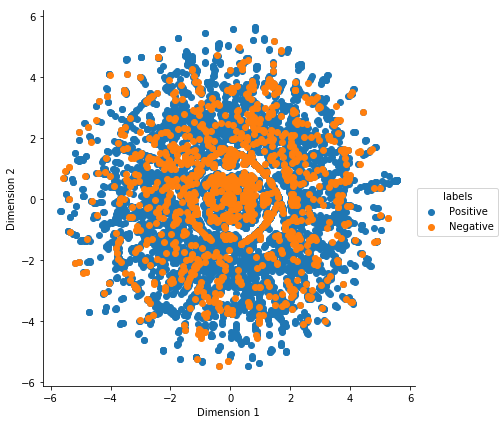


T-SNE Plot for perplexity = 50


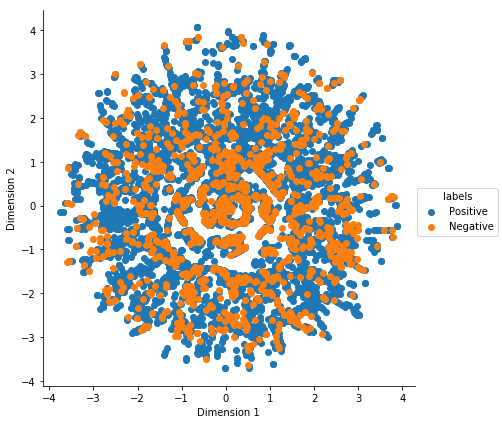


T-SNE Plot for perplexity = 80


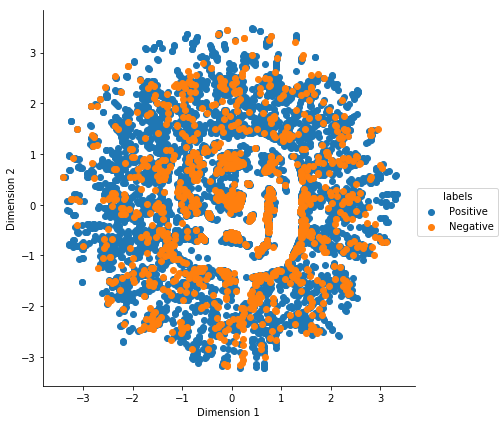

In [7]:
'''T-SNE for TF-IDF model using text reviews. HTML tags and punctuations are removed. All stopwords are preserved.'''

#Using the SQLite Table to read data from a previosuly saved table.
connection_sqlobject = sqlite3.connect('sampled_dataset_PCA_10000.sqlite') 
sampled_dataset = pd.read_sql_query(""" SELECT * FROM Reviews """, connection_sqlobject)

#Initializing the TF-IDF contructor
tf_idf_object = TfidfVectorizer(ngram_range=(1,1))
final_tf_idf_vectors = tf_idf_object.fit_transform(sampled_dataset['RemovedHTML']).toarray()
print("The type of count vectorizer : ",type(tf_idf_object))
print("The shape of the TFIDF vectorizer : ",final_tf_idf_vectors.shape)
print("The number of unique words : ", len(final_tf_idf_vectors[0]))

#Column Standardization of the TF-IDF vectors.
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler(with_mean=False)
standardized_data = scalar.fit_transform(final_tf_idf_vectors)
print(standardized_data.shape)
print("Standardization Done")

#Creating a dataframe using the 'standardized_data' matrix.
dataset = pd.DataFrame(standardized_data)
labels = sampled_dataset['SentimentPolarity']
print("The length of the labels is : {}".format(len(labels)))

#Free memory allocations. 'standardized_data' and 'final_tf_idf_vectors' matrices are no longer needed.
del(final_tf_idf_vectors, standardized_data, sampled_dataset)

#Plot the t-sne 
print("\nPlotting the TSNE for the TF-IDF model.")
tsne(dataset, labels, 20)  #T-SNE with perplexity = 20
tsne(dataset, labels, 50)  #T-SNE with perplexity = 50
tsne(dataset, labels, 80)  #T-SNE with perplexity = 80 

### Creating the Average Word2Vec using a 100 dimensional vector representation of each word.

The size of the Word2Vec text corpus :  10000
The number of words that occured minimum 5 times :  7451
Print sample words from the word2vec_words list :  ['Okay', 'so', 'I', 'work', 'at', 'a', 'Family', 'in', 'St', 'Louis', 'we', 'just', 'got', 'these', 'Well', 'for', 'awhile', 'had', 'been', 'looking', 'the', 'Snickers', 'my', 'mom', 'because', 'now', 'it', 's', 'job', 'along', 'with', 'It', 'freaking', 'good', 'you', 'can', 't', 'go', 'wrong', 'what', 'ever', 'We', 'have', 'enjoyed', 'using', 'this', 'product', 'like', 'specially', 'cooking']
The lenght of the sentence vectors : 10000
Size of each vector :  100
(10000, 100)
Standardization Done
The length of the labels is : 10000

Plotting the TSNE for the Average Word2Vec model.

T-SNE Plot for perplexity = 20


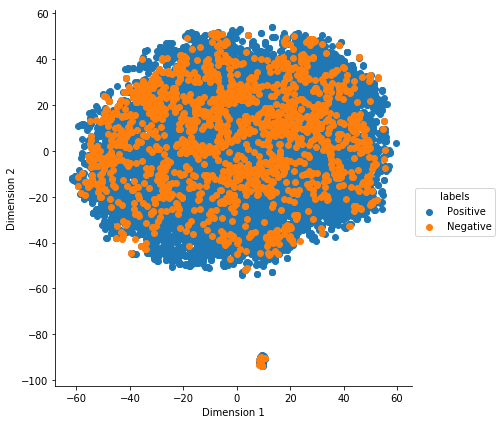


T-SNE Plot for perplexity = 50


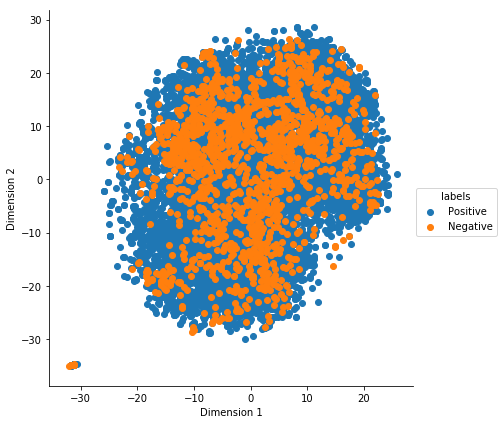


T-SNE Plot for perplexity = 80


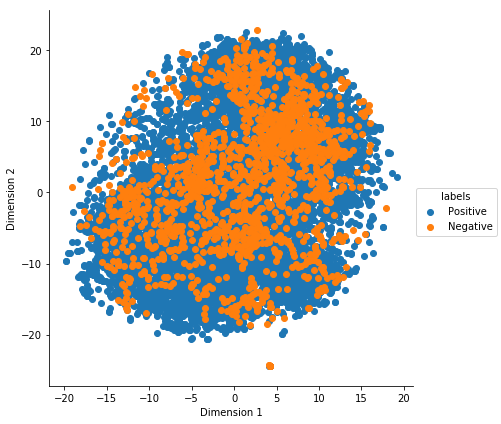

In [6]:
'''T-SNE for the average word2vec model for each review in the sampled Amazon dataset.'''

#Using the SQLite Table to read data from a previosuly saved table.
connection_sqlobject = sqlite3.connect('sampled_dataset_PCA_10000.sqlite') 
sampled_dataset = pd.read_sql_query(""" SELECT * FROM Reviews """, connection_sqlobject)

#Training Word2Vec model from review text using the Amazon reviews dataset.
#HTML tags and punctuations are removed. Stopwords are preserved.
word2vec_corpus=[]
for sentence in sampled_dataset['RemovedHTML'].values:
    word2vec_corpus.append(sentence.split()) #Returns a list of list of all the sentences
print("The size of the Word2Vec text corpus : ",len(word2vec_corpus))

#min_count = 5 considers only those words for our model which occurs atleast 5 times
word2vec_model=Word2Vec(sentences=word2vec_corpus, size=100, min_count=5, workers=6)
word2vec_words = list(word2vec_model.wv.vocab)
print("The number of words that occured minimum 5 times : ",len(word2vec_words))
print("Print sample words from the word2vec_words list : ", word2vec_words[0:50])

#Checking most similar words present for any given word.
word2vec_model.wv.most_similar('run')

# Creating average Word2Vec model by computing the average word2vec for each review.
sent_vectors = []; #The average word2vec for each sentence/review will be stored in this list
for sentence in word2vec_corpus: #For each review
    sent_vec = np.zeros(100) #100 dimensional array, where all elements are zero. This is used to add word vectors and find the averages at each iteration.
    count_words =0; #This will store the count of the words with a valid vector in each review text
    for word in sentence: #For each word in a given review.
        if word in word2vec_words:
            word_vectors = word2vec_model.wv[word] #Creating a vector(numpy array of 100 dimensions) for each word.
            sent_vec += word_vectors
            count_words += 1
    if count_words != 0:
        sent_vec /= count_words
    sent_vectors.append(sent_vec)
print("The lenght of the sentence vectors :",len(sent_vectors))
print("Size of each vector : ",len(sent_vectors[0]))
sent_vectors = np.array(sent_vectors)

#Column Standardization of the Average word2vec vector
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler(with_mean=True)
standardized_data = scalar.fit_transform(sent_vectors)
print(standardized_data.shape)
print("Standardization Done")

#Creating a dataframe using the standardized_data matrix.
dataset = pd.DataFrame(standardized_data)
labels = sampled_dataset['SentimentPolarity']
print("The length of the labels is : {}".format(len(labels)))

#Free memory allocations. 'sent_vectors', 'sent_vec', and 'standardized_data' matrices are no longer needed.
del(sent_vectors, standardized_data, sent_vec, sentence, sampled_dataset)

#Plot the t-sne 
print("\nPlotting the TSNE for the Average Word2Vec model.")
tsne(dataset, labels, 20)  #T-SNE with perplexity = 20
tsne(dataset, labels, 50)  #T-SNE with perplexity = 50
tsne(dataset, labels, 80)  #T-SNE with perplexity = 80

### Creating a TF-IDF weighted Average Word2Vec model.

(10000, 100)
Standardization Done
The shape of the dataset is : (10000, 100)
The length of the labels is : 10000

Plotting the TSNE for the TF-IDF weighted Average Word2Vec model.

T-SNE Plot for perplexity = 20


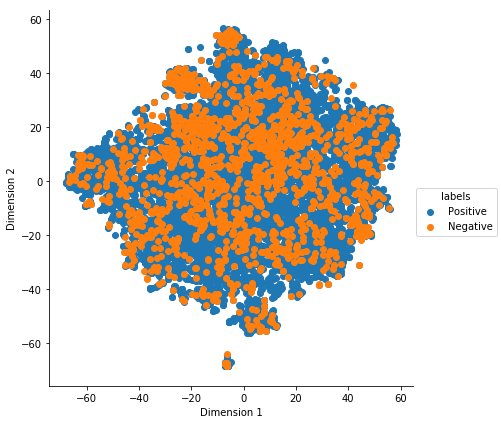


T-SNE Plot for perplexity = 50


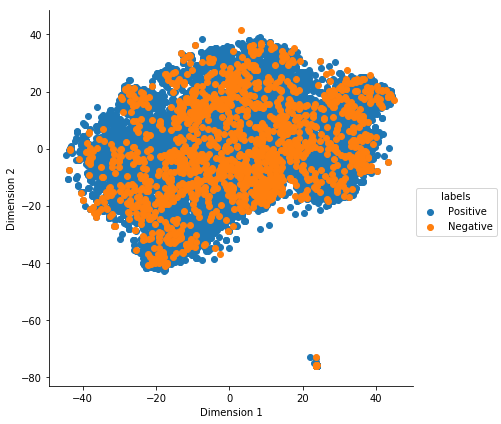


T-SNE Plot for perplexity = 80


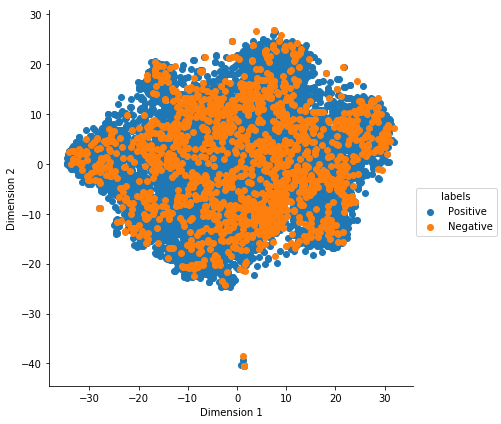

In [5]:
'''T-SNE using TF-IDF weighted Average Word2Vec model on the Amazon dataset.'''

#Using the SQLite Table to read data from a previosuly saved table.
connection_sqlobject = sqlite3.connect('sampled_dataset_PCA_10000.sqlite') 
sampled_dataset = pd.read_sql_query(""" SELECT * FROM Reviews """, connection_sqlobject)

#word2vec_corpus will store the list of words for each review.
word2vec_corpus=[]
for sentence in sampled_dataset['RemovedHTML'].values:
    word2vec_corpus.append(sentence.split())

#min_count = 5 considers only those words which occurs atleast 5 times
word2vec_model=Word2Vec(sentences=word2vec_corpus, size=100, min_count=5, workers=6)
word2vec_words = list(word2vec_model.wv.vocab)

#Initializing the TF-IDF contructor with review texts. HTML tags and punctuations are removed. Stopwords are preserved.
tf_idf_object = TfidfVectorizer(ngram_range=(1,1))
final_tf_idf_vectors = tf_idf_object.fit_transform(sampled_dataset['RemovedHTML'].values)
tfidf_features = tf_idf_object.get_feature_names() 

#Algorithm for finding the TF-IDF weighted average word2vec vectors.
tfidf_sent_vectors = []; #The tfidf-w2v for each sentence/review will stored in this list
row=0;
for sentence in word2vec_corpus: #For each review/sentence 
    sent_vec = np.zeros(100) #100 dimensional array, where all elements are zero. This is used to add word vectors and find the averages at each iteration.
    weight_sum =0; #This will store the count of the words with a valid vector in each review text.
    for word in sentence: #For each word in a review/sentence
        if((word in word2vec_words) and (word in tfidf_features)):
            word_vectors = word2vec_model.wv[word]
            tf_idf = final_tf_idf_vectors[row, tfidf_features.index(word)] #tf_idfidf of a word in a sentence/review
            sent_vec += (word_vectors * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
tfidf_sent_vectors = np.array(tfidf_sent_vectors)

#Column Standardization of the TF-IDF vector
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler(with_mean=True)
standardized_data = scalar.fit_transform(tfidf_sent_vectors)
print(standardized_data.shape)
print("Standardization Done")
    
#Creating a dataframe from the standardized_data matrix
dataset = pd.DataFrame(standardized_data)
print("The shape of the dataset is : {}".format(dataset.shape))

#Picking up the labels from the final dataset
labels = sampled_dataset['SentimentPolarity']
print("The length of the labels is : {}".format(len(labels)))

#Free memory allocations. 'sent_vectors', 'sent_vec', and 'standardized_data', 'sampled_dataset' matrices are no longer needed.
del(tfidf_sent_vectors, standardized_data, sent_vec, sentence, sampled_dataset)

#Plot the t-sne 
print("\nPlotting the TSNE for the TF-IDF weighted Average Word2Vec model.")
tsne(dataset, labels, 20)  #T-SNE with perplexity = 20
tsne(dataset, labels, 50)  #T-SNE with perplexity = 50
tsne(dataset, labels, 80)  #T-SNE with perplexity = 80

### Observation :

1. It's pretty hard to seperate the positive or negative reviews by drawing a Hyperplane on all four feature representations.
2. The data is pretty much non linearly seperated as found from the above 12 T-SNE plots.